# Minimum Vertex Cover
(see also [Wikipedia](https://en.wikipedia.org/wiki/Vertex_cover))

To be able to directly compare to the [Pennylane implementation](https://github.com/PennyLaneAI/pennylane/blob/master/pennylane/qaoa/cost.py), we employ the following cost function:

$$
    \hat C = -\frac 34 \sum_{(i, j) \in E(G)} (\hat Z_i \hat Z_j  +  \hat Z_i  +  \hat Z_j)  + \sum_{i \in V(G)} \hat Z_i,
$$

where $E(G)$ is the set of edges and $V(G)$ is the set of vertices of the graph $G$ (we have a global minus sign since we _maximize_ the cost function).

In [79]:
using DrWatson
@quickactivate "QAOA.jl"

include("../src/QAOA.jl")

using PyPlot
PyPlot.plt.style.use("paper.mplstyle")
using PyCall
np = pyimport("numpy")
nx = pyimport("networkx");

The following graph should be the same as [in this example](https://pennylane.ai/qml/demos/tutorial_qaoa_intro.html):

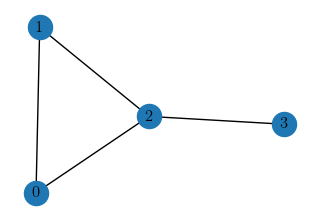

In [2]:
N = 4
graph = nx.gnp_random_graph(N, 0.5, seed=7) 

figure(figsize=(3, 2))
nx.draw(graph, with_labels=true)

In [3]:
h = -ones(N)
J = zeros(N, N)

4×4 Matrix{Float64}:
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0

Note that we have to __shift the edges by 1__ when going from Python to Julia:

In [4]:
for edge in graph.edges
    h[edge[1] + 1] += 3/4.
    h[edge[2] + 1] += 3/4.
    J[(edge .+ (1, 1))...] = 3/4.
end
println(h)
J

[0.5, 0.5, 1.25, -0.25]


4×4 Matrix{Float64}:
 0.0  0.75  0.75  0.0
 0.0  0.0   0.75  0.0
 0.0  0.0   0.0   0.75
 0.0  0.0   0.0   0.0

Since our algorithm _maximizes_ the cost function, we put in __extra minus signs__ for the problem parameters.

In [5]:
p = 2
problem = QAOA.Problem(p, -h, -J)

Main.QAOA.Problem
  num_qubits: Int64 4
  num_layers: Int64 2
  local_fields: Array{Real}((4,)) Real[-0.5, -0.5, -1.25, 0.25]
  couplings: Array{Real}((4, 4)) Real[-0.0 -0.75 -0.75 -0.0; -0.0 -0.0 -0.75 -0.0; -0.0 -0.0 -0.0 -0.75; -0.0 -0.0 -0.0 -0.0]
  driver: YaoBlocks.ConstGate.XGate X


__Gradient optimization with [Zygote](https://fluxml.ai/Zygote.jl/latest/):__

In [6]:
learning_rate = 0.01
cost, params, probs = QAOA.optimize_parameters(problem, vcat([0.5 for _ in 1:p], [0.5 for _ in 1:p]); learning_rate=learning_rate)

(1.9649341584194717, [0.48615867835201454, 0.2870174109818036, 0.28212724428385044, 0.6744919980520789], [0.010304739834811092, 0.004730241649145178, 0.004730241649145177, 0.01814531631878305, 0.04574210959878468, 0.2784461710988903, 0.27844617109889, 0.046443292480159507, 0.0021179793212440187, 0.010039586539297055, 0.010039586539297048, 0.17413614704267616, 0.002711820742822407, 0.0414040422372753, 0.0414040422372753, 0.031158511611503202])

__Optimization with [NLopt](https://nlopt.readthedocs.io/en/latest/):__

In [7]:
cost, params, probs = QAOA.optimize_parameters(problem, vcat([0.5 for _ in 1:p], [0.5 for _ in 1:p]), :LN_COBYLA)

(1.9649364529194528, [0.4861620945749506, 0.287023132879605, 0.28227047493008617, 0.6754107266255658], [0.01034725247993744, 0.0047816695474304245, 0.004781669547430437, 0.01815050095871333, 0.04564422567830565, 0.27852810951358387, 0.2785281095135839, 0.04625685223911709, 0.0021039413830081493, 0.010024352578295254, 0.010024352578295244, 0.17429455800083335, 0.0026970605792319487, 0.041370161667550594, 0.041370161667550615, 0.031097022067132656])

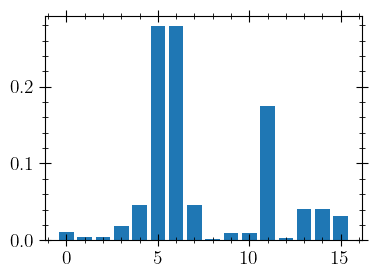

In [8]:
figure(figsize=(4, 3))
bar(0:2^N-1, probs)
tight_layout()

The states `5` $\equiv |1010\rangle$ and `6` $\equiv |0110\rangle$ are indeed the correct solutions! Observe that `Yao.jl` uses the _opposite_ order when decoding binaries compared to, e.g., Pennylane (i.e. our solution `5` is their solution `10`).

### Other drivers

In [80]:
problem_XX = QAOA.Problem(p, -h, -J, [X, X])
QAOA.optimize_parameters(problem_XX, vcat([0.5 for _ in 1:p], [0.5 for _ in 1:p]); learning_rate=learning_rate)

(1.9180563139862967, [0.2391259557078586, 0.17435590375998966, 0.27976650074093784, 0.48534381164519474], [0.001241035253788404, 0.007169308099244508, 0.007169308099244497, 0.005212767417562185, 0.1536750628684488, 0.2258546403502082, 0.22585464035020814, 0.10608072126580746, 0.010622019801067674, 0.01693503294926426, 0.01693503294926428, 0.06041241613371428, 0.005212767417562185, 0.07743558186623642, 0.0774355818662364, 0.0027540833121427735])

In [81]:
problem_XX_YY = QAOA.Problem(p, -h, -J, [[X, X], [Y, Y]])
QAOA.optimize_parameters(problem_XX_YY, vcat([0.5 for _ in 1:p], [0.5 for _ in 1:p]); learning_rate=learning_rate)

(1.8430325875155034, [0.21731461819533393, 0.16018832545194436, 0.42137663445415224, 0.5838104715744677], [0.0007756723035568988, 0.004279004850906716, 0.004279004850906717, 0.006343081329668009, 0.23728982174693763, 0.20380501602683154, 0.2038050160268315, 0.06249999999999999, 0.004152168551249152, 0.0017980131343389753, 0.0017980131343389764, 0.06250000000000006, 0.006343081329668012, 0.06250000000000003, 0.06250000000000006, 0.07533210671476641])